In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from numpy.linalg import solve

# Base data directory for the thesis project.
DATA = Path(r"C:\Users\bseis\ABthesis\data")

# Weekly CRSP core panels split into training and test periods.
CORE_TRAIN = DATA / "processed" / "crsp_weekly_core_1997-01-01_to_2018-06-29.parquet"
CORE_TEST  = DATA / "processed" / "crsp_weekly_core_2018-06-30_to_2024-12-30.parquet"

# Directory containing analysis outputs (kernels, weights, figures, etc.).
ANALYSIS = DATA / "analysis"

# Saved unconstrained GMRP weights estimated on the training window.
B_GMRP = ANALYSIS / "b_gmrp_unconstrained_qp.parquet"

# Global constants used throughout the analysis.
WEEKS_PER_YEAR = 52

# Fixed random number generator for reproducibility.
RNG = np.random.default_rng(123)

# Plot and display defaults for readability.
plt.rcParams["figure.dpi"] = 140
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 100)

In [75]:
def load_returns_from_core(path: Path, ret_col_candidates=("ret_total", "ret")) -> pd.DataFrame:
    # Load a processed CRSP weekly core file and reshape it into a wide
    # date × PERMNO return matrix. We pick the first available return
    # column from the provided candidates.
    df = pd.read_parquet(path).copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["permno"] = pd.to_numeric(df["permno"], errors="coerce").astype("Int64")

    col = None
    for c in ret_col_candidates:
        if c in df.columns:
            col = c
            break
    if col is None:
        raise ValueError(f"No return column found in {ret_col_candidates}")

    wide = (
        df.pivot_table(index="date", columns="permno", values=col, aggfunc="last")
          .sort_index()
          .dropna(how="all")
          .clip(lower=-0.99, upper=5.0)
    )

    # Force integer PERMNO columns so intersections and joins behave cleanly.
    wide.columns = wide.columns.astype("int64", copy=False)
    return wide


def metrics_from_logrets(
    logrets: pd.Series,
    label: str,
    weeks_per_year: int = 52,
    rf_weekly: float = 0.0,
):
    # Compute a compact set of portfolio diagnostics from weekly log returns.
    # This includes growth rates, volatility, Sharpe-style ratios, drawdowns,
    # and terminal wealth, all derived directly from the log-return series.
    x = logrets.dropna()
    T = x.shape[0]
    if T == 0:
        return dict(
            label=label,
            weeks=0,
            kelly_growth_w=np.nan,
            kelly_growth_yr=np.nan,
            vol_w=np.nan,
            vol_yr=np.nan,
            arith_mu_w=np.nan,
            sharpe_w=np.nan,
            max_drawdown=np.nan,
            final_wealth_x=np.nan,
        )

    mu_w = float(x.mean())
    vol_w = float(x.std(ddof=1)) if T > 1 else 0.0

    # Wealth path implied by log returns.
    wealth = np.exp(x.cumsum())
    dd = float((wealth / wealth.cummax() - 1.0).min())

    # Annualized quantities.
    g_yr = mu_w * weeks_per_year
    vol_yr = vol_w * np.sqrt(weeks_per_year)

    # Approximate arithmetic mean return from log moments.
    arith_mu = float(np.expm1(mu_w + 0.5 * vol_w**2))

    # Weekly Sharpe-style ratio using arithmetic mean.
    sharpe = (arith_mu - rf_weekly) / max(vol_w, 1e-12)

    return dict(
        label=label,
        weeks=T,
        kelly_growth_w=mu_w,
        kelly_growth_yr=g_yr,
        vol_w=vol_w,
        vol_yr=vol_yr,
        arith_mu_w=arith_mu,
        sharpe_w=sharpe,
        max_drawdown=dd,
        final_wealth_x=float(wealth.iloc[-1]),
    )


def newey_west_tstat(x: pd.Series, lags: int | None = None):
    # Compute a Newey–West (HAC) t-statistic for the mean of a series,
    # using a Bartlett kernel. Intended for weekly return or
    # return-difference series with serial correlation.
    v = x.dropna().to_numpy()
    T = v.size
    if T == 0:
        return np.nan, np.nan, 0

    mu = v.mean()

    # Default lag choice follows a common rule-of-thumb.
    if lags is None:
        lags = int(np.floor(4 * (T / 100) ** (2 / 9))) or 1

    z = v - mu
    gamma0 = (z @ z) / T
    s = gamma0

    for k in range(1, lags + 1):
        w = 1 - k / (lags + 1)
        gk = (z[k:] @ z[:-k]) / T
        s += 2 * w * gk

    var_mu = s / T
    se = np.sqrt(max(var_mu, 1e-18))
    return mu / se, se, lags


def circular_block_bootstrap_means(
    series: pd.Series,
    block_len: int = 12,
    B: int = 5000,
    rng=np.random.default_rng(123),
):
    # Circular block bootstrap for the mean of a time series.
    # Blocks are drawn with wrap-around to preserve dependence,
    # and we return the full distribution of bootstrap means.
    x = np.asarray(series.dropna().values, float)
    T = len(x)
    if T == 0:
        raise ValueError("Empty series for bootstrap.")

    block_len = int(min(max(1, block_len), T))
    idx = np.arange(T)
    nblocks = int(np.ceil(T / block_len))

    out = np.empty(B, float)
    for b in range(B):
        starts = rng.integers(0, T, size=nblocks)
        boot_idx = np.concatenate(
            [idx[s : (s + block_len)] % T for s in starts]
        )[:T]
        out[b] = x[boot_idx].mean()

    return out

In [77]:
# Load weekly returns from the pre-split core panels.
ret_train = load_returns_from_core(CORE_TRAIN)
ret_test  = load_returns_from_core(CORE_TEST)

print("Train:", ret_train.shape, "|", ret_train.index.min().date(), "→", ret_train.index.max().date())
print("Test: ", ret_test.shape,  "|", ret_test.index.min().date(),  "→", ret_test.index.max().date())

# Load the saved GMRP weights (expected to be PERMNO-indexed).
b_gmrp = pd.read_parquet(B_GMRP)["weight"].astype(float)
b_gmrp.index = pd.Index(pd.to_numeric(b_gmrp.index, errors="coerce").astype("int64"), name="permno")

# Drop any rows that failed PERMNO coercion or have missing weights.
b_gmrp = b_gmrp.dropna()
print("Loaded GMRP weights:", b_gmrp.shape)

# Work on the intersection of the training return columns and the GMRP name set.
universe = ret_train.columns.intersection(b_gmrp.index)
if len(universe) == 0:
    raise RuntimeError("No overlap between GMRP names and train returns.")

ret_train_u = ret_train[universe].copy()

# Renormalize GMRP weights onto the working universe.
b_g = b_gmrp.reindex(universe).fillna(0.0)
b_g = b_g / b_g.sum()

# Training covariance used for Σ-space diagnostics and GMV.
Sigma = ret_train_u.cov().astype(float)
Sigma = 0.5 * (Sigma + Sigma.T)
Sigma = Sigma.fillna(0.0)
n = Sigma.shape[0]

# GMV (shorts allowed): w ∝ (Σ + τI)^{-1} 1 to avoid singular solves.
tau = 1e-6 * np.trace(Sigma.values) / n
S_spd = Sigma.values + tau * np.eye(n)
one = np.ones(n)
w_gmv = solve(S_spd, one)
w_gmv = w_gmv / w_gmv.sum()
w_gmv = pd.Series(w_gmv, index=universe)

# Compare in-sample Σ variance under the same covariance estimate.
var_gmrp = float(b_g.values @ (Sigma.values @ b_g.values))
var_gmv  = float(w_gmv.values @ (Sigma.values @ w_gmv.values))
print(
    f"Train Σ variance — GMRP: {var_gmrp:.6e} | GMV: {var_gmv:.6e} | "
    f"ratio (GMRP/GMV): {var_gmrp/var_gmv:.2f}×"
)

Train: (1123, 3185) | 1996-12-27 → 2018-06-29
Test:  (340, 1583) | 2018-06-29 → 2024-12-27
Loaded GMRP weights: (60,)
Train Σ variance — GMRP: 1.195939e-03 | GMV: 2.071582e-04 | ratio (GMRP/GMV): 5.77×


In [79]:
def weekly_weights_preserve_net_gross(base_w: pd.Series, avail_mask: np.ndarray):
    """
    Reweight base_w onto the subset of names that have returns this week.

    Targets:
      - net exposure:  sum(w_avail) = 1
      - gross exposure: sum(|w_avail|) ≈ sum(|base_w|)

    The idea is to scale the positive and negative legs separately so the long book
    and short book keep their original sizes. If one side disappears entirely,
    it falls back to a simple proportional renormalization on the available names.
    """
    w0 = base_w.reindex_like(base_w).to_numpy(float)
    pos = np.maximum(w0, 0.0)
    neg = np.minimum(w0, 0.0)

    pos_sum_total = pos.sum()
    neg_sum_total = -neg.sum()

    pos_av_sum = np.where(avail_mask, pos, 0.0).sum()
    neg_av_sum = np.where(avail_mask, -neg, 0.0).sum()

    out = np.zeros_like(w0)

    # Rescale the long side across available long names.
    if pos_av_sum > 0:
        scale_pos = pos_sum_total / pos_av_sum if pos_av_sum > 0 else 0.0
        out += np.where(avail_mask, pos * scale_pos, 0.0)

    # Rescale the short side across available short names.
    if neg_av_sum > 0:
        scale_neg = neg_sum_total / neg_av_sum if neg_av_sum > 0 else 0.0
        out += -np.where(avail_mask, (-neg) * scale_neg, 0.0)

    # If one side has no available names, revert to a basic renormalization.
    if (pos_av_sum == 0) or (neg_av_sum == 0):
        w_tmp = np.where(avail_mask, w0, 0.0)
        s = w_tmp.sum()
        out = (w_tmp / s) if s != 0 else np.where(avail_mask, 1.0 / avail_mask.sum(), 0.0)

    # Final net-exposure fix so weights sum exactly to 1.
    net = out.sum()
    if not np.isclose(net, 1.0, atol=1e-12):
        k = int(avail_mask.sum())
        if k > 0:
            out += (1.0 - net) / k * avail_mask.astype(float)

    return out

def portfolio_log_returns_static_preserve_gross(ret_df: pd.DataFrame, base_w: pd.Series):
    # Weekly log returns under a static base weight vector, using gross-preserving
    # reweighting whenever some names are missing that week.
    base_w = base_w.reindex(ret_df.columns).fillna(0.0)
    rows = []
    for _, row in ret_df.iterrows():
        mask = row.notna().values
        if not mask.any():
            rows.append(0.0)
            continue
        w_t = weekly_weights_preserve_net_gross(base_w, mask)
        r_t = float(np.nansum(w_t * row.values))
        rows.append(np.log1p(r_t))
    return pd.Series(rows, index=ret_df.index, name="logret")

In [81]:
# Test universe = names present in both the test return panel and the training-weight universe.
test_universe = ret_test.columns.intersection(universe)
ret_test_u = ret_test[test_universe].copy()

# Map weights onto the test universe and renormalize to sum=1.
# Gross exposure is handled later via the week-by-week reweighting routine.
b_g_test   = b_g.reindex(test_universe).fillna(0.0)
b_g_test   = b_g_test / b_g_test.sum()
w_gmv_test = w_gmv.reindex(test_universe).fillna(0.0)
w_gmv_test = w_gmv_test / w_gmv_test.sum()

# Quick coverage check: how much absolute weight is actually “active” each week.
abs_w = np.abs(b_g_test.values)
cov = ret_test_u.notna().to_numpy().dot(abs_w) / max(abs_w.sum(), 1e-12)
cov_s = pd.Series(cov, index=ret_test_u.index)
print(
    "GMRP weighted coverage (test) — min/median/max:",
    f"{cov_s.min():.3f}/{cov_s.median():.3f}/{cov_s.max():.3f}"
)

# Out-of-sample weekly log returns under gross-preserving missing-data handling.
lr_gmrp_oos = portfolio_log_returns_static_preserve_gross(ret_test_u, b_g_test)
lr_gmv_oos  = portfolio_log_returns_static_preserve_gross(ret_test_u, w_gmv_test)

# Summary metrics for the out-of-sample window.
mt_gmrp = metrics_from_logrets(lr_gmrp_oos, "GMRP | OOS", weeks_per_year=WEEKS_PER_YEAR)
mt_gmv  = metrics_from_logrets(lr_gmv_oos,  "GMV  | OOS", weeks_per_year=WEEKS_PER_YEAR)

pd.DataFrame([mt_gmrp, mt_gmv]).set_index("label")[[
    "weeks",
    "kelly_growth_w",
    "kelly_growth_yr",
    "vol_yr",
    "arith_mu_w",
    "sharpe_w",
    "max_drawdown",
    "final_wealth_x",
]]

GMRP weighted coverage (test) — min/median/max: 0.947/0.962/1.000


,weeks,kelly_growth_w,kelly_growth_yr,vol_yr,arith_mu_w,sharpe_w,max_drawdown,final_wealth_x
label,,,,,,,,
GMRP | OOS,340,0.002044,0.106283,0.377367,0.003419,0.065334,-0.625468,2.003568
GMV | OOS,340,0.000091,0.004735,0.269498,0.000790,0.021131,-0.492410,1.031443


In [83]:
# Compare OOS growth rates via log-return differences (GMRP minus GMV).
print("Hypothesis test (OOS 2018–2024): GMRP vs GMV (Kelly growth differences)")

d = (lr_gmrp_oos - lr_gmv_oos).dropna()
print("N weekly obs:", len(d))

# Point estimate: average weekly log-growth differential.
mu_diff = float(d.mean())

# HAC t-stat for the mean (Newey–West with an automatic lag choice if not specified).
t, se, L = newey_west_tstat(d)

# Block bootstrap CI for the mean, preserving short-run dependence.
boot_means = circular_block_bootstrap_means(d, block_len=12, B=5000, rng=RNG)
ci_lo, ci_hi = np.percentile(boot_means, [2.5, 97.5])

print(f"Δμ_log (GMRP − GMV) = {mu_diff:.6e} /wk | t_NW = {t:.2f} (L={L}, se={se:.2e})")
print(f"95% bootstrap CI (weekly): [{ci_lo:.6e}, {ci_hi:.6e}]")
print(f"Annualized Δ: [{ci_lo*WEEKS_PER_YEAR:.6e}, {ci_hi*WEEKS_PER_YEAR:.6e}]")

=== Hypothesis test (OOS 2018–2024): GMRP vs GMV (Kelly growth differences) ===
N weekly obs: 340
Δμ_log (GMRP − GMV) = 1.952855e-03 /wk | t_NW = 1.18 (L=5, se=1.65e-03)
95% bootstrap CI (weekly): [-1.334524e-03, 5.307051e-03]
Annualized Δ: [-6.939524e-02, 2.759666e-01]


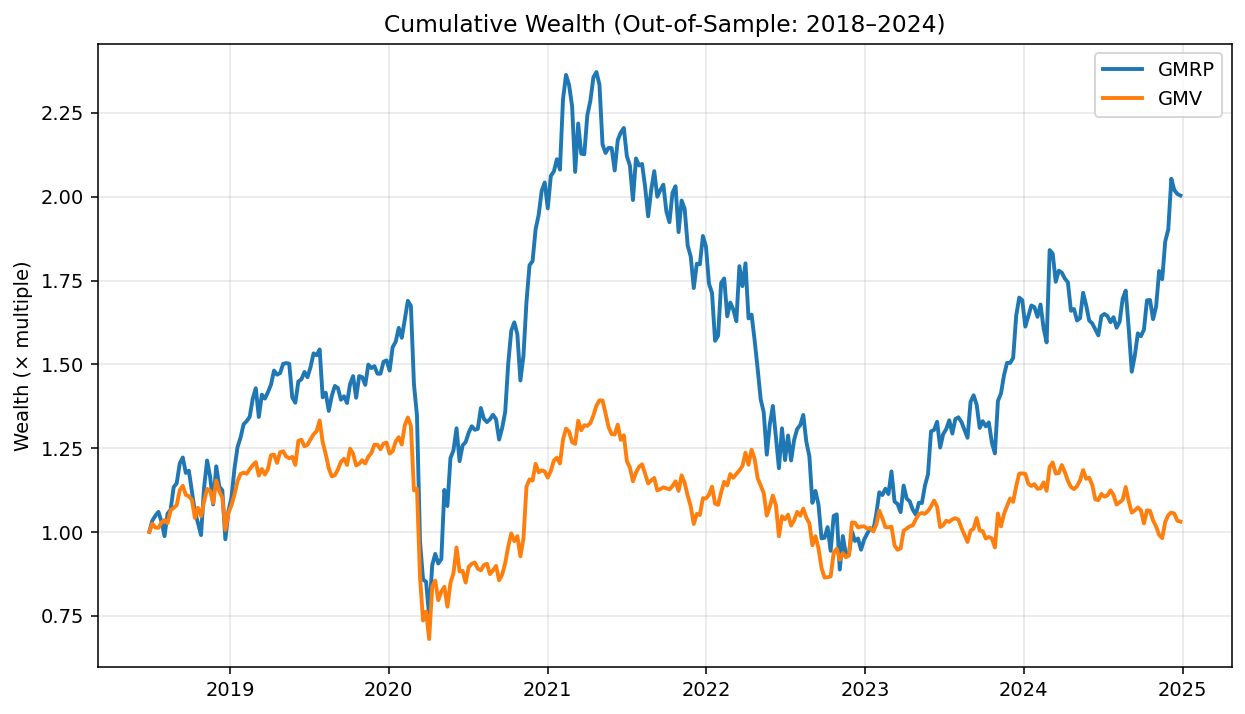

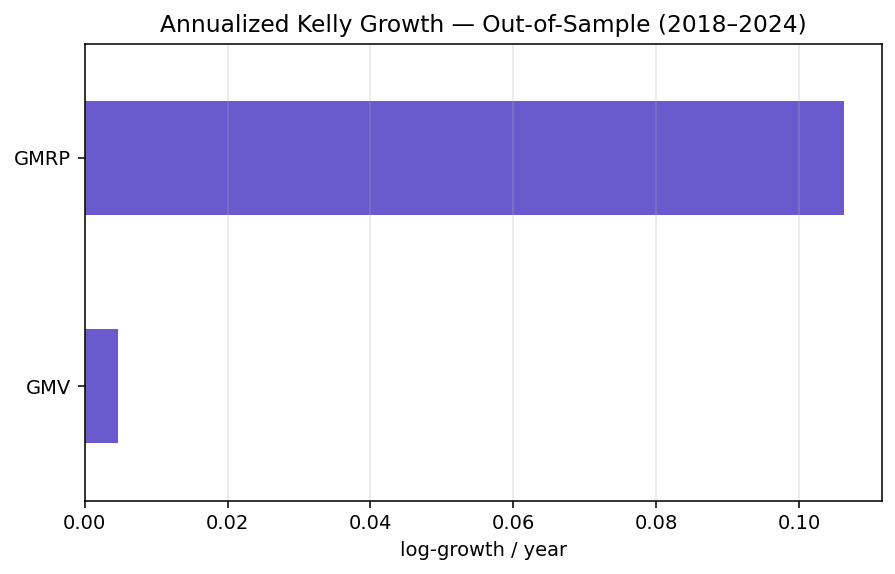

In [85]:
# Cumulative wealth
wealth_oos = pd.DataFrame({
    "GMRP": np.exp(lr_gmrp_oos.cumsum()),
    "GMV":  np.exp(lr_gmv_oos.cumsum()),
})
plt.figure(figsize=(9,5.2))
for col in wealth_oos.columns:
    plt.plot(wealth_oos.index, wealth_oos[col], lw=2, label=col)
plt.title("Cumulative Wealth (Out-of-Sample: 2018–2024)")
plt.ylabel("Wealth (× multiple)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Annualized Kelly growth
g_oos = pd.Series({
    "GMRP": lr_gmrp_oos.mean()*WEEKS_PER_YEAR,
    "GMV":  lr_gmv_oos.mean()*WEEKS_PER_YEAR,
})
plt.figure(figsize=(6.5,4.2))
g_oos.sort_values().plot(kind="barh", color="slateblue")
plt.title("Annualized Kelly Growth — Out-of-Sample (2018–2024)")
plt.xlabel("log-growth / year")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()